In [1]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
# bring in data
data = pd.read_csv('../data/regional_univariate_data.csv')
enc = pd.read_csv('../data/regional_datasets/univariate/enc_data_univ.csv').drop(columns = 'Unnamed: 0')
esc = pd.read_csv('../data/regional_datasets/univariate/esc_data_univ.csv').drop(columns = 'Unnamed: 0')
midatl = pd.read_csv('../data/regional_datasets/univariate/mid_atlantic_data_univ.csv').drop(columns = 'Unnamed: 0')
mount = pd.read_csv('../data/regional_datasets/univariate/mountain_data_univ.csv').drop(columns = 'Unnamed: 0')
ne = pd.read_csv('../data/regional_datasets/univariate/new_england_data_univ.csv').drop(columns = 'Unnamed: 0')
pac = pd.read_csv('../data/regional_datasets/univariate/pacific_data_univ.csv').drop(columns = 'Unnamed: 0')
satl = pd.read_csv('../data/regional_datasets/univariate/south_atlantic_data_univ.csv').drop(columns = 'Unnamed: 0')
wnc = pd.read_csv('../data/regional_datasets/univariate/wnc_data_univ.csv').drop(columns = 'Unnamed: 0')
wsc = pd.read_csv('../data/regional_datasets/univariate/wsc_data_univ.csv').drop(columns = 'Unnamed: 0')

# prepare data
def prepare_and_split_data(data, test_size = 0.15):
    data = data.sort_values('date')
    testsize = int(len(data) * (1-test_size))
    train, test = data[0:testsize], data[testsize:]
    return train, test

enc_train, enc_test = prepare_and_split_data(enc)
esc_train, esc_test = prepare_and_split_data(esc)
midatl_train, midatl_test = prepare_and_split_data(midatl)
mount_train, mount_test = prepare_and_split_data(mount)
ne_train, ne_test = prepare_and_split_data(ne)
pac_train, pac_test = prepare_and_split_data(pac)
satl_train, satl_test = prepare_and_split_data(satl)
wnc_train, wnc_test = prepare_and_split_data(wnc)
wsc_train, wsc_test = prepare_and_split_data(wsc)
print("Length enc train: ", len(enc_train))
print("Length enc test: ", len(enc_test))

Length enc train:  822
Length enc test:  146


In [11]:
def search_auto_arima(train, test, m = [1, 7, 12], max_q = 7, max_p = 7, max_Q = 7, max_P = 7): 
    models = {}
    for val in m:
        auto_model = auto_arima(enc_train['new_confirmed'], seasonal=True, m=val, suppress_warnings=True, stepwise=True, max_q=max_q, max_p=max_p, max_Q = max_Q, max_P = max_P)
        n_periods = len(test['new_confirmed'])
        forecast = auto_model.predict(n_periods=n_periods)
        actuals = test['new_confirmed']

        mae = mean_absolute_error(actuals, forecast)
        rmse = np.sqrt(mean_squared_error(actuals, forecast))
        mase = mean_absolute_scaled_error(actuals, forecast, y_train=train['new_confirmed'])
        print(mase)

        models[val] = (auto_model, mase, mae, rmse, forecast)
    best_model = min(models, key = lambda k: models[k][1])
    model, mase, mae, rmse, forecast = models[best_model]
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"MASE: {mase}")
    print(model.summary())

    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test['new_confirmed'], label='New Cases', color = 'blue')
    plt.plot(test['new_confirmed'].index, forecast, label='Predicted New Cases', color = 'red')
    plt.title('Actual and Predicted Daily New Cases')
    plt.xlabel('Date')
    plt.ylabel('New Cases')
    plt.legend()
    plt.show()

# ENC

1.1220320119437992
1.2814734946195547
4.084107514648901
1.0894797866163126
MAE: 8640.296604339856
RMSE: 10628.236240163375
MASE: 1.0894797866163126
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  822
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 14)   Log Likelihood               -8801.224
Date:                             Sat, 02 Mar 2024   AIC                          17614.447
Time:                                     13:16:24   BIC                          17642.710
Sample:                                          0   HQIC                         17625.291
                                             - 822                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

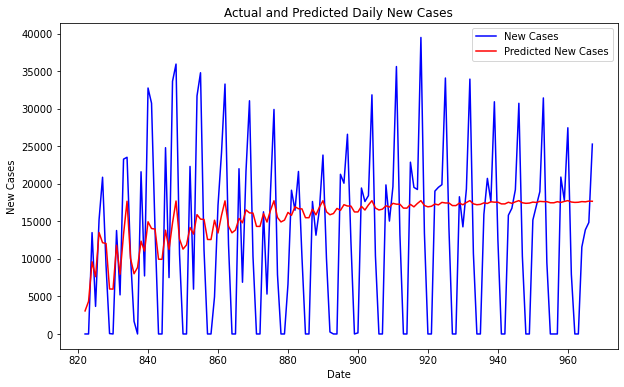

In [22]:
search_auto_arima(enc_train, enc_test, m = [1, 2,  7, 14], max_q = 21, max_p = 14, max_P = 14, max_Q = 21)

In [8]:
auto_model = auto_arima(enc_train['new_confirmed'], seasonal=True, m=1, suppress_warnings=True, stepwise=True, max_q=7, max_p=7, max_Q = 7, max_P = 7)

n_periods = len(enc_test['new_confirmed'])
forecast = auto_model.predict(n_periods=n_periods)

actuals = enc_test['new_confirmed']

mae = mean_absolute_error(actuals, forecast)

rmse = np.sqrt(mean_squared_error(actuals, forecast))

y_train = enc_train['new_confirmed']
mase = mean_absolute_scaled_error(actuals, forecast, y_train=y_train)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MASE: {mase}")

print(auto_model.summary())

MAE: 9194.052195112905
RMSE: 11269.654462297894
MASE: 1.1593044177024705
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  822
Model:               SARIMAX(7, 1, 5)   Log Likelihood               -8676.015
Date:                Sat, 02 Mar 2024   AIC                          17378.030
Time:                        12:19:41   BIC                          17439.266
Sample:                             0   HQIC                         17401.525
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0219      0.025     -0.889      0.374      -0.070       0.026
ar.L2         -0.0035      0.026     -0.136      0.892    

/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


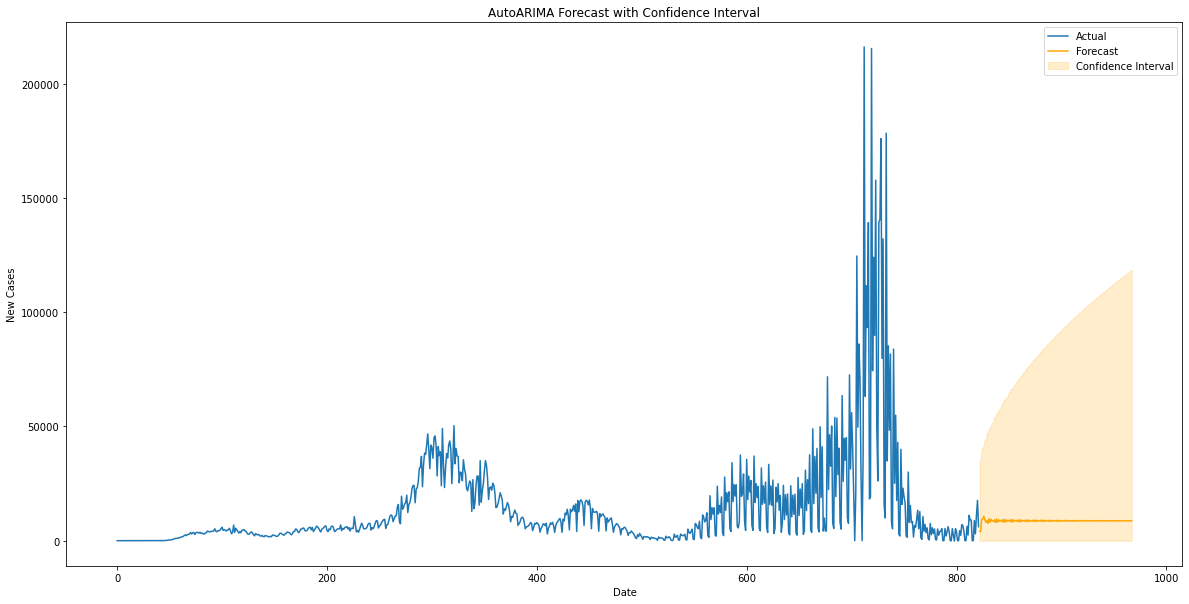

In [11]:
forecast, conf_int = auto_model.predict(n_periods=len(enc_test), return_conf_int=True)
for i in conf_int:
    if i[0] < 0:
        i[0] = 0

#test_dates =  #pd.date_range(df.index[-1], periods=n_periods + 1, freq=df.index.freq)[-n_periods:]
plt.figure(figsize= (20,10))
plt.plot(np.array(enc_train.index), np.array(enc_train['new_confirmed']), label='Actual')

plt.plot(np.array(enc_test.index), np.array(forecast), label='Forecast', color='orange')

plt.fill_between(enc_test.index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.legend()
plt.show()

In [20]:
def log_transform(x):
    return np.log(x) if x > 0 else 0

log_auto_model = auto_arima(enc_train['new_confirmed'].apply(lambda x: log_transform(x)), seasonal=True, m=1, suppress_warnings=True, stepwise=True, max_q=4, max_p=4, max_Q = 4, max_P = 4)
print(log_auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  822
Model:               SARIMAX(4, 1, 4)   Log Likelihood               -1103.283
Date:                Fri, 23 Feb 2024   AIC                           2224.567
Time:                        11:10:27   BIC                           2266.962
Sample:                             0   HQIC                          2240.833
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8526      0.017     51.008      0.000       0.820       0.885
ar.L2         -1.3263      0.022    -60.445      0.000      -1.369      -1.283
ar.L3          0.6824      0.019     35.528      0.0

/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


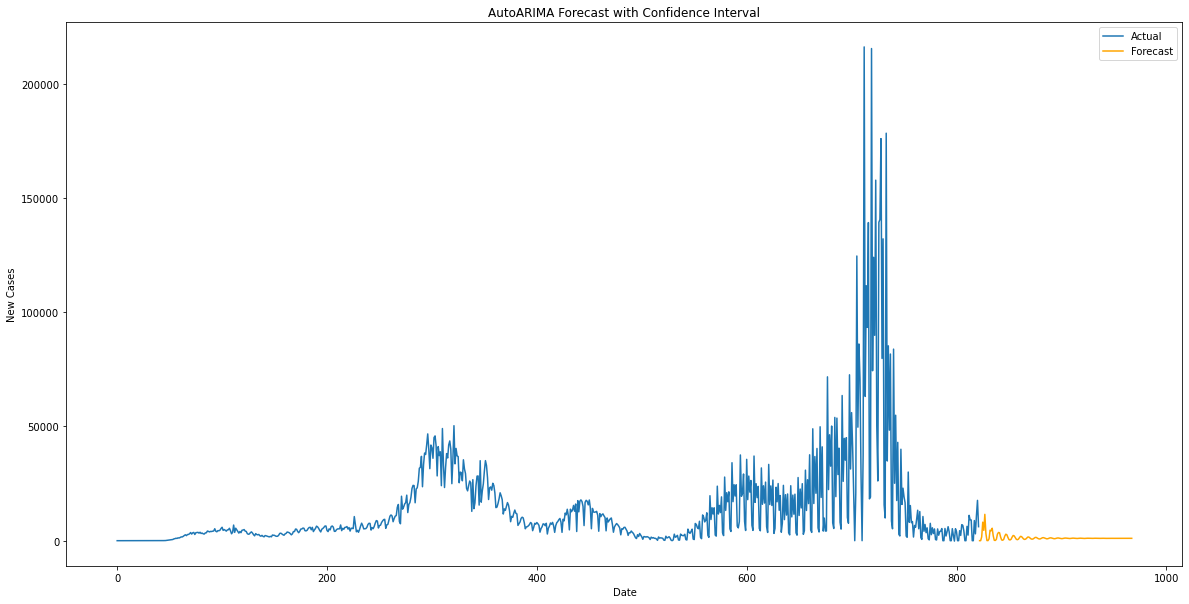

In [28]:
forecast, conf_int = log_auto_model.predict(n_periods=len(enc_test), return_conf_int=True)
forecast = np.exp(forecast)
conf_int = np.exp(conf_int)
# for i in conf_int:
#     if i[0] < 0:
#         i[0] = 0

#test_dates =  #pd.date_range(df.index[-1], periods=n_periods + 1, freq=df.index.freq)[-n_periods:]
plt.figure(figsize= (20,10))
plt.plot(np.array(enc_train.index), np.array(enc_train['new_confirmed']), label='Actual')

plt.plot(np.array(enc_test.index), np.array(forecast), label='Forecast', color='orange')

# plt.fill_between(enc_test.index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.legend()
plt.show()

# ESC

1.7680635893630041
8.078958875345618
3.1141236663565994
MAE: 5858.776969867258
RMSE: 6950.192387470907
MASE: 1.7680635893630041
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  822
Model:               SARIMAX(7, 1, 5)   Log Likelihood               -8676.015
Date:                Sat, 02 Mar 2024   AIC                          17378.030
Time:                        13:00:52   BIC                          17439.266
Sample:                             0   HQIC                         17401.525
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0219      0.025     -0.889      0.374      -0.070       0.026
ar.

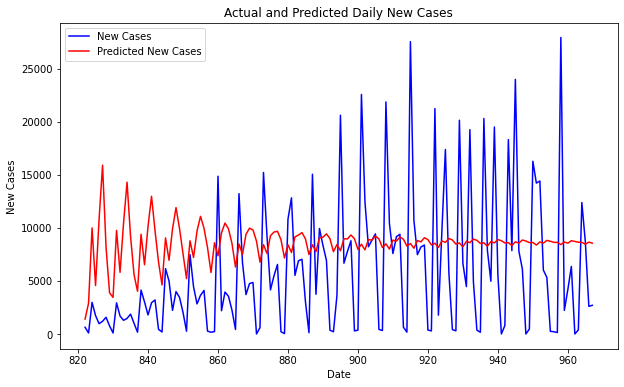

In [18]:
search_auto_arima(esc_train, esc_test, m = [1, 7, 14], max_q = 21, max_Q = 21)

# MidAtl

2.763340801208206
14.834780959398415
3.034251449156996
MAE: 5858.952297367049
RMSE: 7665.484802341048
MASE: 2.763340801208206
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  822
Model:               SARIMAX(7, 1, 5)   Log Likelihood               -8676.015
Date:                Sat, 02 Mar 2024   AIC                          17378.030
Time:                        13:04:36   BIC                          17439.266
Sample:                             0   HQIC                         17401.525
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0219      0.025     -0.889      0.374      -0.070       0.026
ar.L2

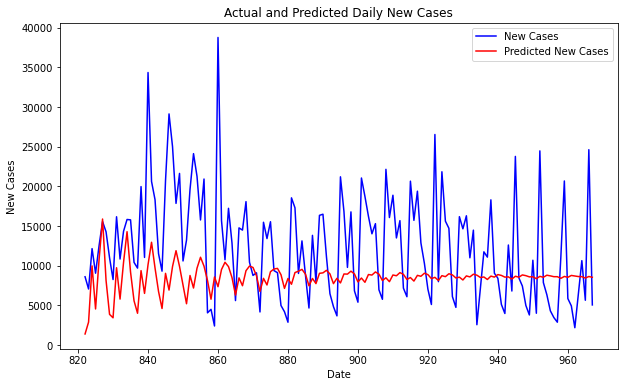

In [19]:
search_auto_arima(midatl_train, midatl_test, m = [1, 7, 14], max_q = 21, max_Q = 21)

# Mountain

1.789259247088245
8.427136731873798
3.29180724573657
MAE: 5658.189118817407
RMSE: 7300.279978068899
MASE: 1.789259247088245
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  822
Model:               SARIMAX(7, 1, 5)   Log Likelihood               -8676.015
Date:                Sat, 02 Mar 2024   AIC                          17378.030
Time:                        13:18:56   BIC                          17439.266
Sample:                             0   HQIC                         17401.525
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0219      0.025     -0.889      0.374      -0.070       0.026
ar.L2  

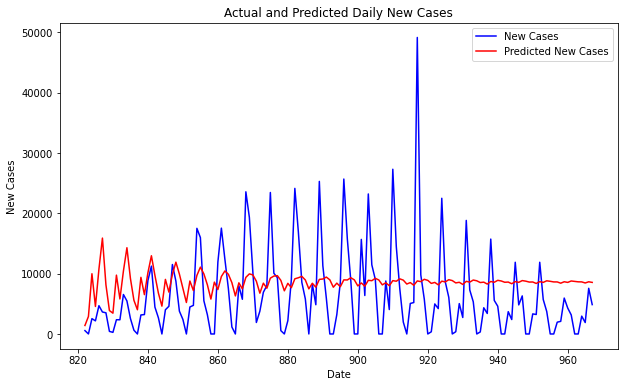

In [23]:
search_auto_arima(mount_train, mount_test, m = [1, 7, 14], max_q = 21, max_Q = 21)

# New England

2.247445009980481
9.471631647683406
4.732457888783665
MAE: 5603.583934080565
RMSE: 6216.419813218778
MASE: 2.247445009980481
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  822
Model:               SARIMAX(7, 1, 5)   Log Likelihood               -8676.015
Date:                Sun, 03 Mar 2024   AIC                          17378.030
Time:                        11:34:47   BIC                          17439.266
Sample:                             0   HQIC                         17401.525
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0219      0.025     -0.889      0.374      -0.070       0.026
ar.L2 

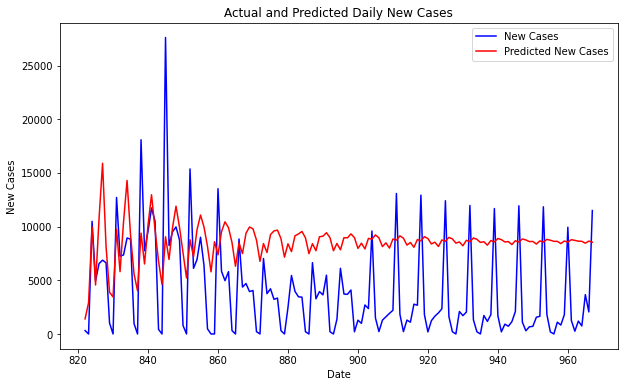

In [24]:
search_auto_arima(ne_train, ne_test, m = [1, 7, 14], max_q = 21, max_Q = 21)

# Pacific

2.2348207943351754
5.647837298119082
2.261293617740218
MAE: 14931.039160252676
RMSE: 21292.59930815855
MASE: 2.2348207943351754
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  822
Model:               SARIMAX(7, 1, 5)   Log Likelihood               -8676.015
Date:                Sun, 03 Mar 2024   AIC                          17378.030
Time:                        11:39:27   BIC                          17439.266
Sample:                             0   HQIC                         17401.525
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0219      0.025     -0.889      0.374      -0.070       0.026
ar.

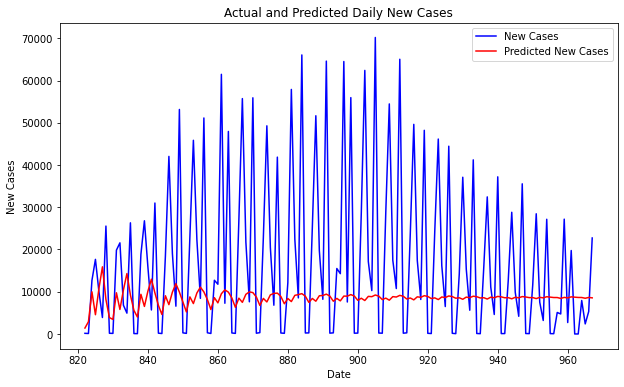

In [25]:
search_auto_arima(pac_train, pac_test, m = [1, 7, 14], max_q = 21, max_Q = 21)

# South Atlantic

1.5624969945290768
3.8622397561386688
1.389527173884831
MAE: 14486.392846439707
RMSE: 20527.015202506813
MASE: 1.389527173884831
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  822
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 14)   Log Likelihood               -8801.224
Date:                             Sun, 03 Mar 2024   AIC                          17614.447
Time:                                     11:41:15   BIC                          17642.710
Sample:                                          0   HQIC                         17625.291
                                             - 822                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

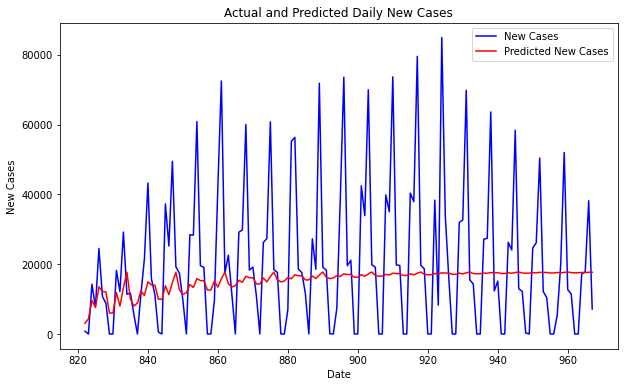

In [26]:
search_auto_arima(satl_train, satl_test, m = [1, 7, 14], max_q = 21, max_Q = 21)

# West North Central

1.4558122044121924
8.066442193487928
3.382227924525838
MAE: 4555.458039890222
RMSE: 5449.705868662594
MASE: 1.4558122044121924
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  822
Model:               SARIMAX(7, 1, 5)   Log Likelihood               -8676.015
Date:                Sun, 03 Mar 2024   AIC                          17378.030
Time:                        11:45:14   BIC                          17439.266
Sample:                             0   HQIC                         17401.525
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0219      0.025     -0.889      0.374      -0.070       0.026
ar.L

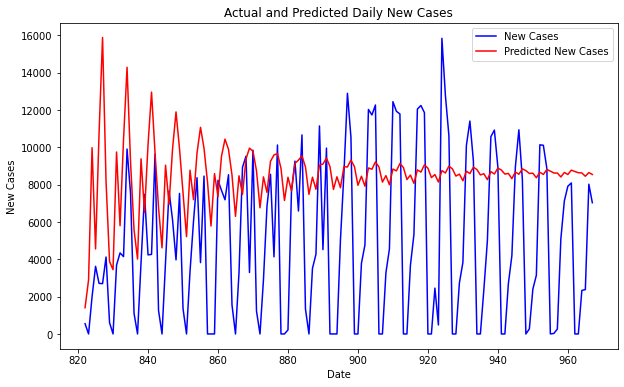

In [27]:
search_auto_arima(wnc_train, wnc_test, m = [1, 7, 14], max_q = 21, max_Q = 21)

# West South Central

1.4909570830377932
6.982854635960833
1.6634547260595938
MAE: 6590.667732040622
RMSE: 8698.666661189543
MASE: 1.4909570830377932
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  822
Model:               SARIMAX(7, 1, 5)   Log Likelihood               -8676.015
Date:                Sun, 03 Mar 2024   AIC                          17378.030
Time:                        11:46:35   BIC                          17439.266
Sample:                             0   HQIC                         17401.525
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0219      0.025     -0.889      0.374      -0.070       0.026
ar.

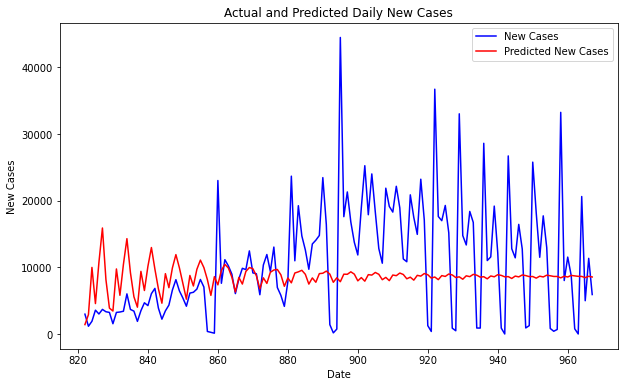

In [28]:
search_auto_arima(wsc_train, wsc_test, m = [1, 7, 14], max_q = 21, max_Q = 21)